# Imports

In [1]:
import pandas as pd
import numpy as np 

from pyhhmm.gaussian import GaussianHMM

import yfinance as yf

import matplotlib.pyplot as plt

# Fetch Data

In [2]:
# Data Extraction
start_date = "2020-06-11"
end_date = "2023-06-11"
symbol = "SPY"

# USE YAHOO FINANCE 
data = yf.download(symbol ,  start_date , end_date )
data = data[["Open" , "High" , "Low" , "Close" ]]

[*********************100%***********************]  1 of 1 completed


In [3]:
# Add Returns and Range    
# Returns = (todays price divided by yesterdays)     # ROI since Yesterday
# Range   = (todays high price divided todays low)   # volitility from highest point to lowest within day

df = data.copy()
df["Returns"] = (df["Close"] / df["Close"].shift(1)) - 1
df["Range"]   = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)

print("Length: ", len(df))

Length:  754


# Add Moving Average

In [4]:
df["12_MA"] = df["Close"].rolling(window=12).mean()
df["21_MA"] = df["Close"].rolling(window=21).mean()

# Train/Test Split Data

In [5]:
# Drop NA
df = df.dropna()

# Split Data into Two sets
train_amount = len(df)//2
test_amount = len(df) - train_amount

x_train = df[["Returns" , "Range"]].iloc[:train_amount]
x_test = df[["Returns" , "Range"]].iloc[test_amount:]
save_df = df.iloc[test_amount:]



print(f"Train Data Length: {len(x_train)}")
print(f"Test Data Length: {len(x_test)}")

Train Data Length: 367
Test Data Length: 367


# Train HMM

In [6]:
# Train Hidden Markov Model
model = GaussianHMM(n_states=4, covariance_type="full" , n_emissions=2)
train = model.train([np.array(x_train.values)])

d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


# Test HMM

In [7]:
# Test Hidden Markov Model
test = model.predict([x_train.values])[0]

# Test Predictions

In [8]:
df_main = save_df.copy()
df_main.drop(columns = ["High" , "Low"], inplace = True)

hmm_results = model.predict([x_train.values])[0]
df_main["HMM"] = hmm_results

# Run BackTest
- if the 12 day moving average is greater than the 21 day moving average, place signal
    -  1 : go long
    -  0 : do nothing
    - -1 : go short

In [9]:
# Signals
df_main.loc[df_main["12_MA"] > df_main["21_MA"] , "MA_Signal" ] = 1
df_main.loc[df_main["12_MA"] <= df_main["21_MA"] , "MA_Signal" ] = 0

# Decide Favorable States

In [10]:
# Check Each row to see if within positive signals from HMM    

# HARDCODED FAVORABLE STATES 
favorable_states = [0,3]


hmm_values = df_main["HMM"].values

# 0 if no   ||   1 if yes
hmm_values = [1 if x in favorable_states else 0 for x in hmm_values]


df_main["HMM_Signal"] = hmm_values

In [11]:
# Add Combined "Main" Signal   (if moving average and HMM signals are green)
df_main["Main_Signal"] = 0
df_main.loc[   (df_main["MA_Signal"] == 1) &  (df_main["HMM_Signal"] == 1 ), "Main_Signal" ] = 1

df_main["Main_Signal"] = df_main["Main_Signal"].shift(1)

In [12]:
# Benchmmark Returns
df_main["lrets_bench"] = np.log(df_main["Close"] / df_main["Close"].shift(1))
df_main["bench_prod"] = df_main["lrets_bench"].cumsum()
df_main["bench_prod_exponent"] = np.exp(df_main["bench_prod"]) - 1

In [13]:
# Strategy Returns
df_main["lrets_strat"] = np.log(df_main["Open"].shift(-1) / df_main["Open"]) * df_main["Main_Signal"]
df_main["lrets_prod"] = df_main["lrets_strat"].cumsum()
df_main["strat_prod_exponent"] = np.exp(df_main["lrets_prod"]) - 1


# Review Results


In [14]:
df_main.dropna(inplace=True)


df_main.tail(10)

,Open,Close,Returns,Range,12_MA,21_MA,HMM,MA_Signal,HMM_Signal,Main_Signal,lrets_bench,bench_prod,bench_prod_exponent,lrets_strat,lrets_prod,strat_prod_exponent
Date,,,,,,,,,,,,,,,,
2023-05-25,414.739990,414.649994,0.008660,0.009093,414.294169,413.127143,0,1.0,1,1.0,0.008623,-0.126574,-0.118891,0.001422,-0.093858,-0.089588
2023-05-26,415.329987,420.019989,0.012951,0.013293,414.891668,413.489524,0,1.0,1,1.0,0.012868,-0.113706,-0.107480,0.016003,-0.077855,-0.074901
2023-05-30,422.029999,420.179993,0.000381,0.009170,415.562500,413.691905,0,1.0,1,1.0,0.000381,-0.113325,-0.107140,-0.008925,-0.086780,-0.083121
2023-05-31,418.279999,417.850006,-0.005545,0.007208,416.084167,413.803333,3,1.0,1,1.0,-0.005561,-0.118886,-0.112091,-0.000454,-0.087235,-0.083538
2023-06-01,418.089996,421.820007,0.009501,0.014708,416.818334,414.326191,1,1.0,0,1.0,0.009456,-0.109430,-0.103655,0.015215,-0.072019,-0.069487
2023-06-02,424.500000,427.920013,0.014461,0.011298,418.290835,415.273811,3,1.0,1,0.0,0.014358,-0.095072,-0.090693,0.000000,-0.072019,-0.069487
2023-06-05,428.279999,427.100006,-0.001916,0.007622,419.280001,416.320002,1,1.0,0,1.0,-0.001918,-0.096990,-0.092435,-0.003766,-0.075786,-0.072985
2023-06-06,426.670013,428.029999,0.002177,0.006080,420.013334,417.053335,1,1.0,0,0.0,0.002175,-0.094815,-0.090459,0.000000,-0.075786,-0.072985
2023-06-07,428.440002,426.549988,-0.003458,0.008237,420.674166,417.710953,3,1.0,1,0.0,-0.003464,-0.098279,-0.093604,-0.000000,-0.075786,-0.072985


# Calculate Metrics

In [15]:
# Sharpe Ratio Function
def sharpe_ratio_calc(returns_series):
    TradingDays = 255
    TradingDays_SQRT = np.sqrt(TradingDays)
    risk_free_rate = 0.01
    mean = returns_series.mean() * TradingDays
    sigma = returns_series.std() * TradingDays_SQRT
    sharpe_ratio = round((mean - risk_free_rate) / sigma , 2 )
    return sharpe_ratio

In [16]:
# Metrics
bench_returns = round(df_main["bench_prod_exponent"].values[-1] * 100 , 1)
strategy_returns = round(df_main["strat_prod_exponent"].values[-1] * 100 , 1)


bench_sharpe = sharpe_ratio_calc(df_main["lrets_bench"].values)
strat_sharpe = sharpe_ratio_calc(df_main["lrets_strat"].values)

In [17]:
# Print metrics
print(f"Returns Benchmark: {bench_returns}%")
print(f"Returns Strategy: {strategy_returns}%")

print("-------------------")

print(f"Sharpe Benchmark: {bench_sharpe}")
print(f"Sharpe Strategy: {strat_sharpe}")



print("\n\n Sharpe ratio is saying 'for every dollar of risk, how many dollars am i getting back?'")

Returns Benchmark: -8.8%
Returns Strategy: -6.6%
-------------------
Sharpe Benchmark: -0.34
Sharpe Strategy: -0.43


 Sharpe ratio is saying 'for every dollar of risk, how many dollars am i getting back?'


# Plot Results

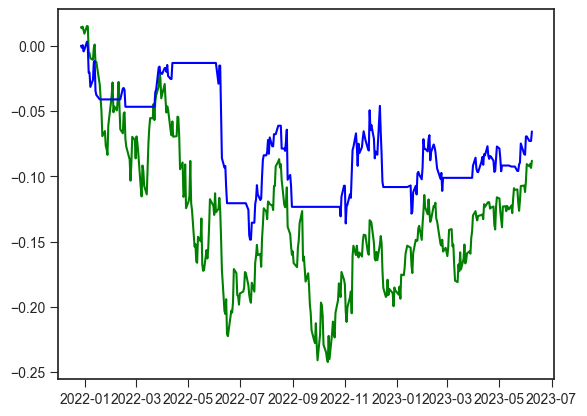

In [18]:
# Plot Equity Curves
fig = plt.Figure(figsize=(18,10))
plt.plot(df_main["bench_prod_exponent"], color="green" )
plt.plot(df_main["strat_prod_exponent"] , color="blue")

plt.show()

# SAVE DATA

In [19]:
df_main.to_csv(f"data-storage/HMM-{symbol}.csv")